In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import trackintel as ti
pfs = ti.io.file.read_positionfixes_csv('pfs.csv', index_col='ID')
sp = ti.io.file.read_staypoints_csv('staypoints.csv', index_col='id')

In [2]:
# Generate locations from the staypoints.
new_sp, locs = ti.preprocessing.staypoints.generate_locations(staypoints=sp, method='dbscan', epsilon=100, num_samples=3, agg_level='user')

/usr/local/lib/python3.9/site-packages/trackintel/geogr/distances.py:227: UserWarning: The CRS of your data is not defined.
  warnings.warn("The CRS of your data is not defined.")
/usr/local/lib/python3.9/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


In [3]:
activity_sp = ti.analysis.location_identification.location_identifier (staypoints= new_sp, pre_filter=True, method='FREQ')

In [4]:
home_sp = activity_sp.loc[activity_sp['purpose'] == 'home']

In [5]:
home_sp

,user_id,started_at,finished_at,geom,location_id,purpose
id,,,,,,
96,4,2022-09-05 12:56:09-04:00,2022-09-05 13:16:09-04:00,POINT (-81.49528 30.33016),11,home
97,4,2022-09-05 13:36:14-04:00,2022-09-05 13:53:05-04:00,POINT (-81.49530 30.33013),11,home
99,4,2022-09-05 16:08:01-04:00,2022-09-05 16:22:23-04:00,POINT (-81.49544 30.33021),11,home
103,4,2022-09-05 16:50:55-04:00,2022-09-05 16:56:51-04:00,POINT (-81.49550 30.32918),11,home
104,4,2022-09-05 16:56:51-04:00,2022-09-05 17:07:47-04:00,POINT (-81.49524 30.33008),11,home
...,...,...,...,...,...,...
240764,11769,2022-10-31 12:23:59-04:00,2022-10-31 12:37:06-04:00,POINT (-81.81474 30.18603),13908,home
240765,11769,2022-10-31 12:37:06-04:00,2022-10-31 12:41:29-04:00,POINT (-81.81280 30.18675),13908,home
240785,11769,2022-10-31 21:10:57-04:00,2022-10-31 21:35:53-04:00,POINT (-81.81492 30.18604),13908,home


In [6]:
ti.io.file.write_staypoints_csv(home_sp, 'home.csv')

In [7]:
import pandas as pd
df = pd.DataFrame()

merge_sp_home = ti.preprocessing.staypoints.merge_staypoints(staypoints=home_sp, triplegs=df,  max_time_gap='30d', agg ={'geom':'first'})
merge_sp_home

,user_id,started_at,finished_at,location_id,geom
id,,,,,
96,4,2022-09-05 12:56:09-04:00,2022-10-31 18:01:08-04:00,11,POINT (-81.49528 30.33016)
1646,73,2022-09-05 12:31:15-04:00,2022-10-15 14:22:18-04:00,95,POINT (-81.73093 30.32482)
3022,85,2022-09-09 12:20:48-04:00,2022-10-13 11:40:10-04:00,181,POINT (-81.61754 30.21459)
3212,88,2022-10-06 03:22:35-04:00,2022-10-15 23:50:08-04:00,195,POINT (-81.78819 30.31113)
3560,102,2022-09-13 11:28:01-04:00,2022-10-31 20:06:34-04:00,220,POINT (-81.63046 30.42400)
...,...,...,...,...,...
234097,10140,2022-10-20 10:18:39-04:00,2022-10-31 21:48:28-04:00,13555,POINT (-81.77666 30.37968)
234749,10277,2022-10-05 13:21:56-04:00,2022-10-15 23:54:50-04:00,13598,POINT (-81.73277 30.38735)
235976,10430,2022-10-08 16:42:40-04:00,2022-10-13 14:03:50-04:00,13672,POINT (-81.61088 30.35405)


In [8]:
# Find the user_id with the most occurrences and Visualization.
top_id = pfs['user_id'].value_counts().idxmax()
pfs_top = pfs.loc[pfs['user_id'] == top_id]
sp_top = home_sp.loc[home_sp['user_id'] == top_id]

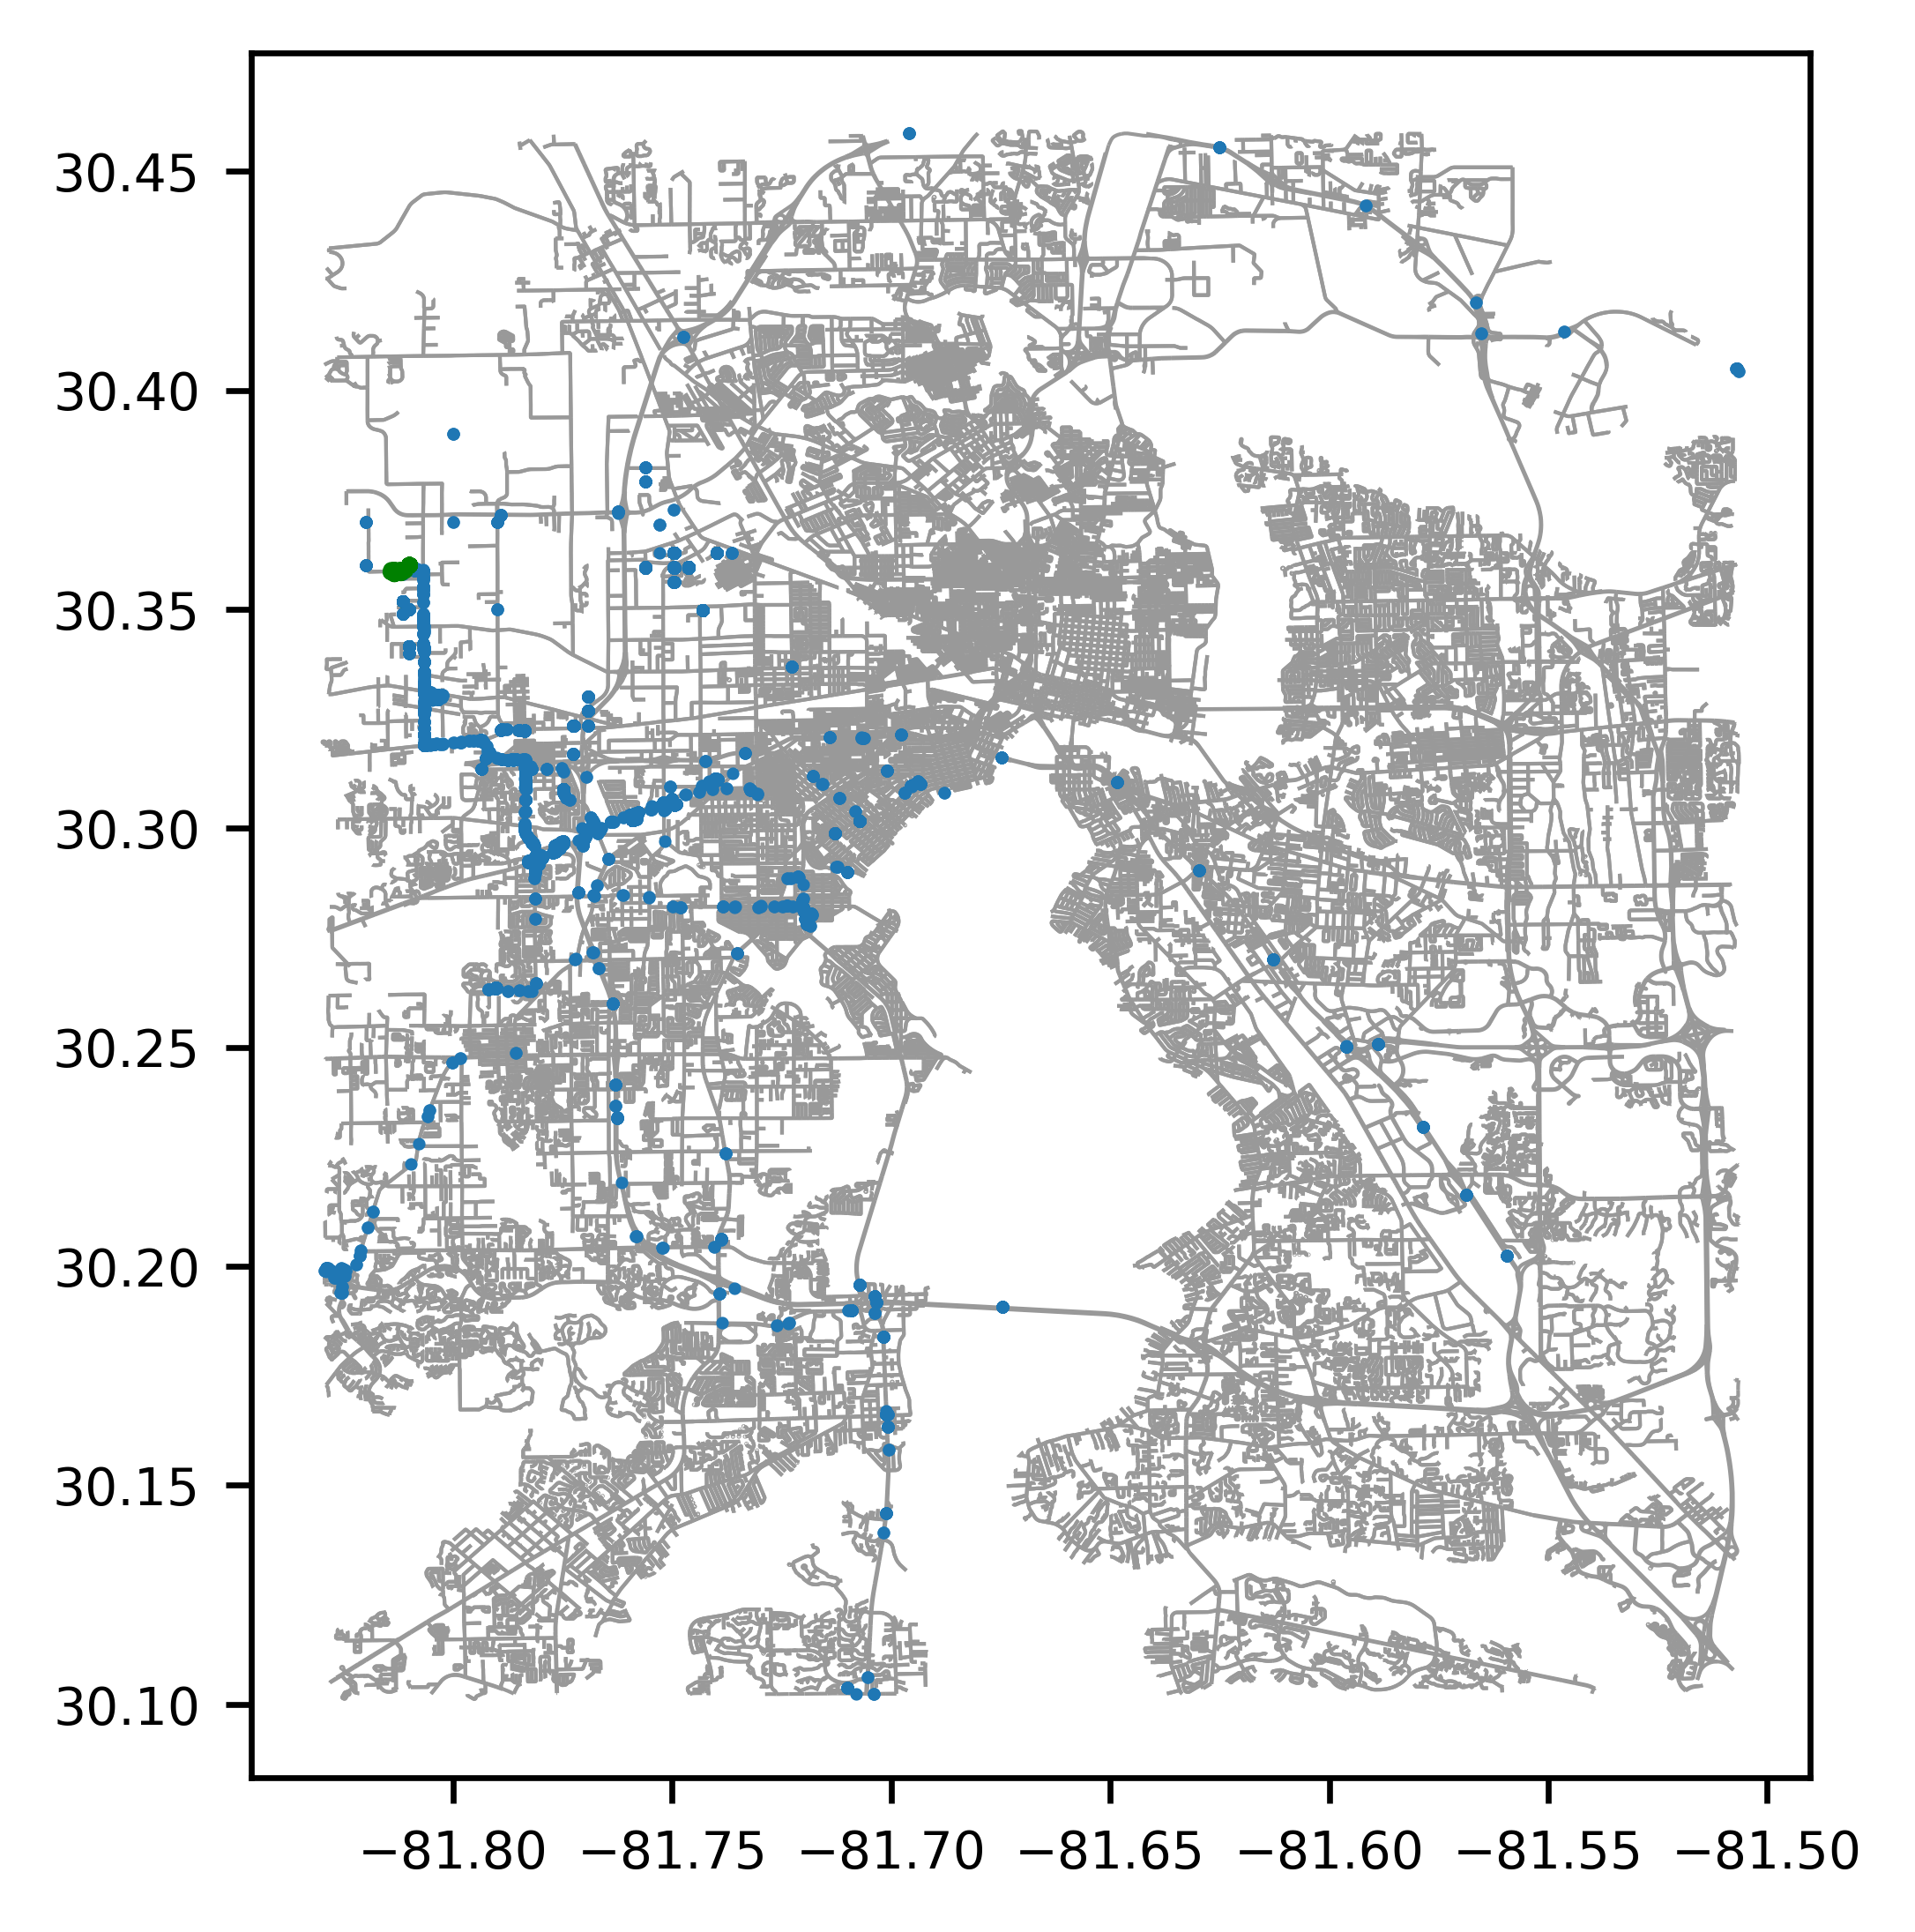

In [9]:
sp_top.as_staypoints.plot(radius=100, positionfixes=pfs_top, plot_osm=True)